# Test 14

_Same as test12 but longer quenches_

The goal of this file is to compute the GS for several angles using MD.

**Simulation with LAMMPS**

Simulations are done by a Ramp (8mT/60s) + Evolution (60s) scheme


**Chirality**

Compute the chirality of the final states for all angles.

$$
    \Phi = \sum_{i,j} (-1)^{i+j}\chi_{ij}
$$

**Charge ordering**

Compute a complementary order parameter with topological charqes

$$
    \kappa = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

**Averaging**
From all the datasets, compute $\langle |\Phi|\rangle$ and $\langle |\kappa|\rangle$, as well as $\sigma_\Phi$ and $\sigma_\kappa$.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
#mpl.use('pgf')
import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# MD Simulations

This part only generates the datasets to work with for all angles.

In [3]:
params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":10e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":(300+60)*ureg.s,
    "framespersec":20*ureg.Hz,
    "dt":1*ureg.ms,
    "max_field":5*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)
params["size"] = 10

#locals().update(params)

In [4]:
def get_md_colloid(params,angle,realization):
    sp = ice.spins()
    
    N = params["size"]
    a = params["lattice_constant"]
    
    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")

    particle = ice.particle(radius = params["particle_radius"],
                susceptibility = params["particle_susceptibility"],
                diffusion = params["particle_diffusion"],
                temperature = params["particle_temperature"],
                density = params["particle_density"])

    trap = ice.trap(trap_sep = params["trap_sep"],
                height = params["trap_height"],
                stiffness = params["trap_stiffness"])

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = params["height_spread"], 
                            susceptibility_spread = params["susceptibility_spread"],
                            periodic = params["isperiodic"])

        
    col.randomize()
    col.region = np.array([[0,0,-3*(params["particle_radius"]/a/N).magnitude],[1,1,3*(params["particle_radius"]/a/N).magnitude]])*N*a


    world = ice.world(
            field = params["max_field"],
            temperature = params["sim_temp"],
            dipole_cutoff = params["sim_dipole_cutoff"],
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = f"./lammps_files/test{realization}",
                include_timestamp = False,
                targetdir = r".",
                framerate = params["framespersec"],
                timestep = params["dt"],
                run_time = params["total_time"],
                output = ["x","y","z","mux","muy","muz"],
                processors=1)

    # Field
    
    angle = angle*ureg("deg")
    angle = angle.to("rad").magnitude
    
    #scaling = (1/np.sqrt(2) - 1)*2/np.pi * angle + 1
    scaling = 1
    
    # This should have 300s of pure quenching
    col.sim.field.fieldx = f"{scaling}*v_Bmag*sin({angle})*time/300e6*(time<300e6)+{scaling}*v_Bmag*sin({angle})*(time>=300e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = f"{scaling}*v_Bmag*cos({angle})*time/300e6*(time<300e6)+{scaling}*v_Bmag*cos({angle})*(time>=300e6)"
        
    col.run_simulation()

    col.load_simulation()

    return col

In [5]:
def jesus_take_the_wheels(params,data_path,angle,realization):
    main_angle_path = data_path + str(angle)
    trj_path = main_angle_path + "/trj/"
    ctrj_path = main_angle_path + "/ctrj/"

    try:
        os.mkdir(main_angle_path)
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass
    
    col = get_md_colloid(params,angle,realization)

    filename = f"trj{realization}.csv"
    col.trj.to_csv(trj_path + filename)

    filename = f"ctrj{realization}.csv"
    trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
    trj.to_csv(ctrj_path + filename)
    
    return None

# MD Sims

This block checks which angles are going to be ran. Helps for running by batches.

In [42]:
angle_completed = os.listdir("../data/test14/angles/")
angles = [angle for angle in range(0,90+1,5) if str(angle) not in angle_completed]
angle_select = angles[:]
angle_select

[]

In [6]:
import concurrent.futures

In [7]:
runs = 15
data_path = "../data/test14/angles/"
realizations = list(range(11,runs+1))
for angle in tqdm(range(5,90+1,5)):
    print(f"===== Angle {angle} =====")

    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        # map the function to the realizations
        results = list(
            executor.map(
                jesus_take_the_wheels,
                [params] * len(realizations),
                [data_path] * len(realizations),
                [angle] * len(realizations),  # Assuming 'angle' is constant
                realizations,
            )
        )
        
    clear_output(wait=True)

100%|██████████| 18/18 [4:21:43<00:00, 872.41s/it]


This section graphs the fields just to check that everything is OK.

In [ ]:
trj_raw = trj = pd.read_csv("../data/test14/angles/90/trj/trj3.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test14/angles/90/ctrj/ctrj3.csv", index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

# Chirality

This section deals with chirality computations for all angles. \
Check the _chirality_tools.py_ for more information.

In [12]:
# General information

particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"])

trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"])


params["particle"] = particle
params["trap"] = trap


In [13]:
angles_completed = np.sort([int(a) for a in os.listdir("../data/test14/angles")])
angles_completed

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90])

In [14]:
last_frame = trj_raw.index.get_level_values("frame").unique()[-1]
state_ctrj = ctrj_raw.loc[idx[last_frame,:]].drop(["t", "type"],axis=1)
col = aux.get_colloids_from_ctrj(state_ctrj,particle,trap,params["particle_radius"],params["lattice_constant"],params["size"])

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))
col.display(ax)

In [15]:
phi = []
runs = 15

for angle in tqdm(angles_completed):
    clear_output(wait=True)

    angle_chirs = [chir.get_chirality_on_realization(params,'test14',angle,i,last_frame=None) for i in range(1,runs+1)]

    phi.append(angle_chirs)

phi

100%|██████████| 19/19 [13:55<00:00, 44.00s/it]


[[6,
  -100,
  -100,
  -100,
  -100,
  -100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  -16],
 [100,
  100,
  -46,
  100,
  100,
  100,
  -100,
  100,
  -100,
  100,
  -100,
  -100,
  -100,
  100,
  -100],
 [100,
  100,
  10,
  -22,
  100,
  -100,
  -100,
  -22,
  -100,
  -100,
  -100,
  100,
  -100,
  -10,
  -100],
 [-100,
  -100,
  100,
  7,
  100,
  100,
  -100,
  -100,
  -100,
  100,
  -100,
  100,
  100,
  100,
  100],
 [100,
  -100,
  -100,
  100,
  100,
  -100,
  100,
  -100,
  100,
  100,
  -100,
  -100,
  7,
  100,
  100],
 [-98,
  4,
  100,
  100,
  -100,
  100,
  -100,
  -10,
  -100,
  -100,
  100,
  100,
  100,
  -100,
  100],
 [63, -96, 3, 50, 18, 0, -86, -97, 20, 50, -37, -32, 68, -4, 74],
 [6, 2, 7, -4, 3, 1, 1, -11, 7, 1, -2, -4, -5, -3, -6],
 [-1, 1, 1, 1, 1, -4, 1, -5, 0, 3, -3, -5, -3, 2, 4],
 [5, 3, -6, -4, 1, -7, -3, -6, 1, 1, 2, 0, -6, -1, 6],
 [-2, -3, 0, -2, 1, -3, 1, -2, 0, -1, -4, 2, -1, 2, 5],
 [1, -2, 1, 1, 1, -1, -1, -2, 0, -2, 0, 1, -1, 0, 1

In [16]:
phi_df = pd.DataFrame(phi)
phi_df.to_csv("../data/test14/chirality.csv")
phi_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,6,-100,-100,-100,-100,-100,100,100,100,100,100,100,100,100,-16
1,100,100,-46,100,100,100,-100,100,-100,100,-100,-100,-100,100,-100
2,100,100,10,-22,100,-100,-100,-22,-100,-100,-100,100,-100,-10,-100
3,-100,-100,100,7,100,100,-100,-100,-100,100,-100,100,100,100,100
4,100,-100,-100,100,100,-100,100,-100,100,100,-100,-100,7,100,100
5,-98,4,100,100,-100,100,-100,-10,-100,-100,100,100,100,-100,100
6,63,-96,3,50,18,0,-86,-97,20,50,-37,-32,68,-4,74
7,6,2,7,-4,3,1,1,-11,7,1,-2,-4,-5,-3,-6
8,-1,1,1,1,1,-4,1,-5,0,3,-3,-5,-3,2,4
9,5,3,-6,-4,1,-7,-3,-6,1,1,2,0,-6,-1,6


In [17]:
phi_df.applymap(np.abs).mean(axis=1)

0     88.133333
1     96.400000
2     77.600000
3     93.800000
4     93.800000
5     87.466667
6     46.533333
7      4.200000
8      2.333333
9      3.466667
10     1.933333
11     1.000000
12     1.066667
13     1.800000
14     2.000000
15     2.200000
16     1.533333
17     1.333333
18     1.600000
dtype: float64

# Complementary order parameter

$$
    Q = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

In [29]:
runs

15

In [24]:
for angle in tqdm(angles_completed):
    print(f"===== Angle {angle} =====")
    for realization in range(1,runs+1):
        print(f"- realization {realization} -")
        
        angle_path = f"../data/test14/angles/{angle}/ctrj/ctrj{realization}.csv"

        try:
            os.mkdir(f"../data/test14/vertices/{angle}")
        except:
            pass

        vertex_path = f"../data/test14/vertices/{angle}/vertices{realization}.csv"
        ctrj = pd.read_csv(angle_path,index_col=[0,1])
        last_frame = ctrj.index.get_level_values("frame").unique().max()
        try:
            vertices = aux.get_vertices_at_frame(ctrj,last_frame)
        except:
            vertices = aux.get_vertices_at_frame(ctrj,last_frame-1)


        vertices.to_csv(vertex_path)

    clear_output(wait=True)

100%|██████████| 19/19 [18:02<00:00, 56.99s/it]


In [30]:
psi= []
for angle in tqdm(angles_completed):
    results = [chir.get_charge_order_on_realization(params,'test14',angle,realization,tol=1.6) for realization in range(1,runs+1) ]
    psi.append(results)

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


In [31]:
psi_df = pd.DataFrame(psi)
psi_df.to_csv("../data/test14/charges.csv")
psi_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
1,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,2.0,6.0,0.0,0.0,0.0,-12.0,0.0,0.0,0.0,0.0,0.0,-14.0,0.0
3,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-18.0,0.0,0.0
5,-2.0,16.0,0.0,0.0,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,14.0,-8.0,18.0,-6.0,12.0,2.0,-22.0,-8.0,-18.0,-16.0,-2.0,-8.0,8.0,8.0,4.0
7,4.0,-14.0,30.0,-6.0,0.0,-26.0,30.0,-16.0,-4.0,2.0,6.0,20.0,-26.0,14.0,-26.0
8,0.0,8.0,-6.0,4.0,34.0,-8.0,20.0,-2.0,-8.0,28.0,14.0,16.0,-20.0,22.0,-16.0
9,54.0,2.0,-40.0,2.0,-30.0,-12.0,-8.0,-18.0,-14.0,28.0,24.0,0.0,-24.0,6.0,-16.0


#  Importing data and plotting

In [32]:
angles_completed = np.sort([int(a) for a in os.listdir("../data/test12/angles")])
phi_df = pd.read_csv("../data/test14/chirality.csv",index_col=0).applymap(np.abs)
psi_df = pd.read_csv("../data/test14/charges.csv",index_col=0).applymap(np.abs)

In [34]:
phi_means = phi_df.mean(axis=1).to_numpy()
phi_sigmas = phi_df.std(axis=1).to_numpy()

psi_means = psi_df.mean(axis=1).to_numpy()
psi_sigmas = psi_df.std(axis=1).to_numpy()


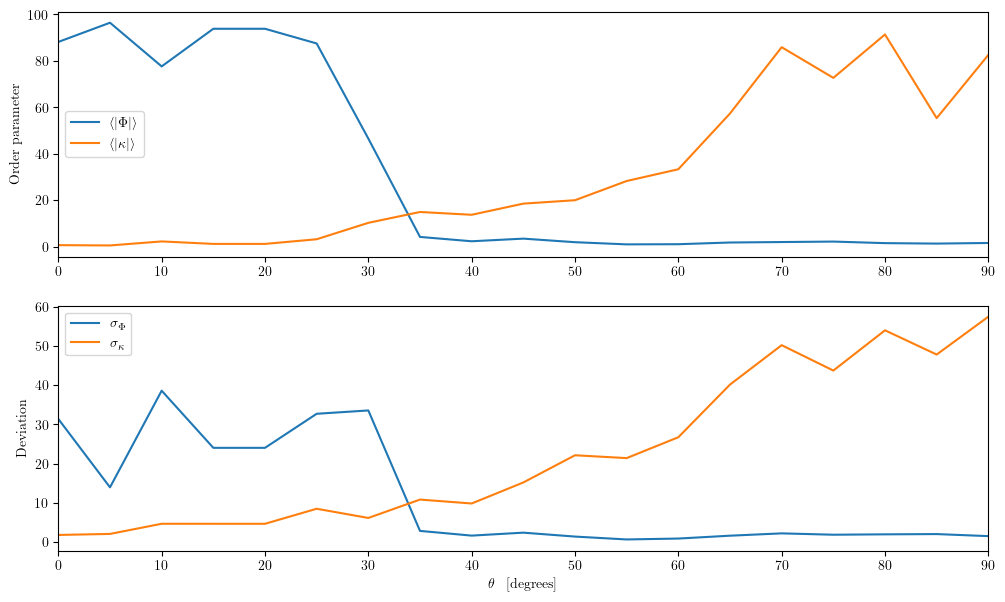

In [35]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

ax = axes[0]
ax.plot(angles_completed,phi_means, label = "$\\langle |\\Phi|\\rangle$")
ax.plot(angles_completed,psi_means, label = "$\\langle |\\kappa|\\rangle$")
ax.set_ylabel("Order parameter")
ax.set_xlim(0,90)
ax.legend()

ax = axes[1]

ax.plot(angles_completed,phi_sigmas, label="$\\sigma_\\Phi$")
ax.plot(angles_completed,psi_sigmas, label="$\\sigma_\\kappa$")

ax.set_xlabel("$\\theta$ \, [degrees]")
ax.set_ylabel("Deviation")

ax.legend()

ax.set_xlim(0,90)

plt.show()

fig.savefig("../data/test12/order_parameters.png",dpi=300)
fig.savefig("../data/test12/order_parameters.pdf")

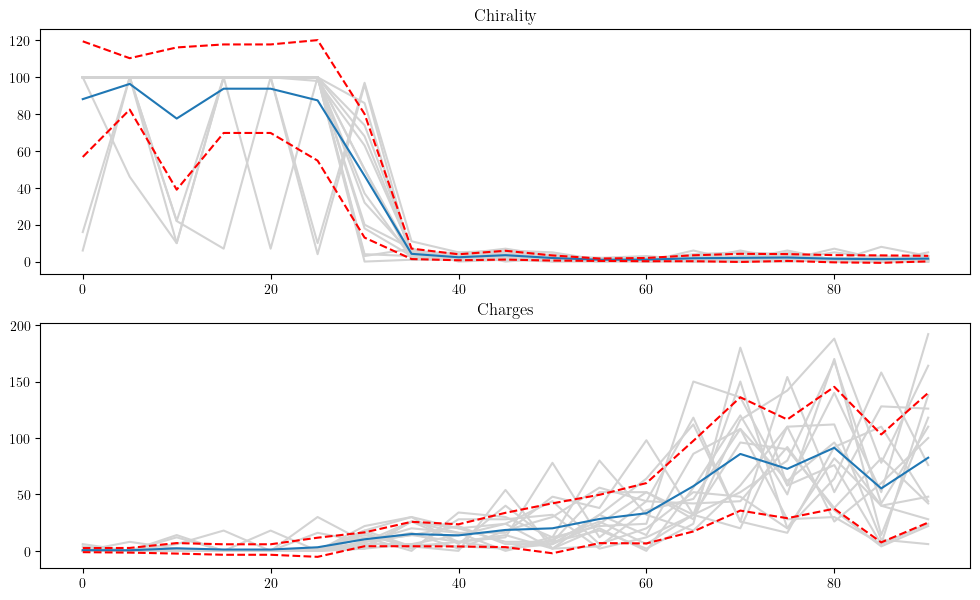

In [38]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

ax = axes[0]
upper = phi_means + phi_sigmas
lower = phi_means - phi_sigmas
ax.plot(angles_completed,phi_df.to_numpy(), color='lightgray')
ax.plot(angles_completed,phi_means)
ax.plot(angles_completed,upper, '--',color='red')
ax.plot(angles_completed,lower, '--',color='red')
ax.set_title('Chirality')


ax = axes[1]
upper = psi_means + psi_sigmas
lower = psi_means - psi_sigmas
ax.plot(angles_completed,psi_df.to_numpy(), color='lightgray')
ax.plot(angles_completed,psi_means)
ax.plot(angles_completed,upper, '--',color='red')
ax.plot(angles_completed,lower, '--',color='red')
ax.set_title('Charges')
plt.show()